In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset_url = '../data/image_classification/train.csv'

In [3]:
data = pd.read_csv(dataset_url, on_bad_lines='skip')

In [4]:
data.head()

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


## Prepare data

### preprocess

In [6]:
%pip install nltk

  Obtaining dependency information for nltk from https://files.pythonhosted.org/packages/4d/66/7d9e26593edda06e8cb531874633f7c2372279c3b0f46235539fe546df8b/nltk-3.9.1-py3-none-any.whl.metadata
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Obtaining dependency information for click from https://files.pythonhosted.org/packages/7e/d4/7ebdbd03970677812aac39c869717059dbb71a4cfc033ca6e5221787892c/click-8.1.8-py3-none-any.whl.metadata
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/80/32/763a6cc01d21fb3819227a1cc3f60fd251c13c37c27a73b8ff4315433a8e/regex-2024.11.6-cp311-cp311-win_amd64.whl.metadata
  Using cached regex-2024.11.6-cp311-cp311-win_amd64.whl.metadata (41 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp311-cp311-win_amd64.whl (274 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Note: you may need to restart the


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jforc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jforc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jforc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jforc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


def preprocess_text(text):
    # normalisation
    text = text.lower()
    
    text = re.sub(r'[^a-z\s]', '', text)
    
    # tokenization
    tokens = word_tokenize(text)
    
    # suppression des stop words english
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)


data['Processed_Caption'] = data['Caption'].apply(preprocess_text)

### embedding with Glove

In [ ]:
import zipfile
import os

import urllib.request

# Download the GloVe embeddings
url = "http://nlp.stanford.edu/data/glove.6B.zip"
filename = "glove.6B.zip"
urllib.request.urlretrieve(url, filename)

# Unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

In [12]:
#Recuperer les embeddings

glove_file = '../data/glove.6B.300d.txt'

embeddings_index = {}

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [16]:
# Encode the processed captions using the GloVe embeddings
def encode_caption(caption, embeddings_index, embedding_dim=300):
    words = caption.split()
    embedding_matrix = np.zeros((len(words), embedding_dim))
    for i, word in enumerate(words):
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return np.mean(embedding_matrix, axis=0)

In [17]:
# Convert the embeddings into a DataFrame with each dimension as a column
embedding_columns = [f"dim_{i}" for i in range(300)]
encoded_captions = data['Processed_Caption'].apply(lambda x: encode_caption(x, embeddings_index))
encoded_captions_df = pd.DataFrame(encoded_captions.tolist(), columns=embedding_columns)

# Concatenate the original DataFrame with the embeddings DataFrame
data = pd.concat([data, encoded_captions_df], axis=1)

In [22]:
data.head()

,ImageID,Labels,Caption,Processed_Caption,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,...,dim_290,dim_291,dim_292,dim_293,dim_294,dim_295,dim_296,dim_297,dim_298,dim_299
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.,woman swim suit holding parasol sunny day,-0.183715,-0.279452,-0.273451,-0.151354,-0.238511,-0.002729,...,0.015428,0.145674,-0.210935,0.135643,-0.065155,-0.015965,0.077749,0.149353,0.039941,0.156539
1,1.jpg,1 19,A couple of men riding horses on top of a gree...,couple men riding horse top green field,-0.112222,0.167935,0.051619,-0.060171,-0.141060,0.037239,...,-0.080701,0.077541,-0.399331,0.073074,0.064750,0.179167,0.028870,0.033079,0.104596,0.074339
2,2.jpg,1,They are brave for riding in the jungle on tho...,brave riding jungle elephant,-0.104130,-0.147420,0.039692,0.108273,-0.014261,0.136308,...,0.015092,0.207167,-0.373578,-0.070615,-0.040367,0.333992,-0.282195,0.345185,0.204967,0.251706
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...,black silver clock tower intersection near tree,-0.239927,-0.025673,-0.033024,-0.293050,-0.115065,0.097724,...,0.164644,0.028476,-0.188698,0.093664,-0.039222,0.201370,0.273574,-0.046140,0.074232,0.105175
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.,train coming stop track side,0.166052,0.105928,0.030769,0.035441,-0.339333,-0.209551,...,-0.050368,-0.224060,-0.257643,0.074137,0.046986,0.190455,0.036208,-0.144133,0.183855,0.131850


### split

_J'utilise le csv que j'ai cree avec le split des images pour avoir la meme repartition_

In [28]:
split_train = pd.read_csv('../data/image_classification/split_train.csv')
split_val = pd.read_csv('../data/image_classification/split_val.csv')
split_test = pd.read_csv('../data/image_classification/split_test.csv')


In [179]:
train = data[data['ImageID'].isin(split_train['ImageID'])].merge(split_train, on='ImageID', how='left')
val = data[data['ImageID'].isin(split_val['ImageID'])].merge(split_val, on='ImageID', how='left')
test = data[data['ImageID'].isin(split_test['ImageID'])].merge(split_test, on='ImageID', how='left')

In [52]:
train.shape, val.shape, test.shape

((21004, 323), (4501, 323), (4491, 323))

In [53]:
train.head()

,ImageID,Labels,Caption_x,Processed_Caption,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,...,9,10,11,13,14,15,16,17,18,19
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.,woman swim suit holding parasol sunny day,-0.183715,-0.279452,-0.273451,-0.151354,-0.238511,-0.002729,...,0,0,0,0,0,0,0,0,0,0
1,2.jpg,1,They are brave for riding in the jungle on tho...,brave riding jungle elephant,-0.104130,-0.147420,0.039692,0.108273,-0.014261,0.136308,...,0,0,0,0,0,0,0,0,0,0
2,3.jpg,8 3 13,a black and silver clock tower at an intersect...,black silver clock tower intersection near tree,-0.239927,-0.025673,-0.033024,-0.293050,-0.115065,0.097724,...,0,0,0,1,0,0,0,0,0,0
3,4.jpg,8 3 7,A train coming to a stop on the tracks out side.,train coming stop track side,0.166052,0.105928,0.030769,0.035441,-0.339333,-0.209551,...,0,0,0,0,0,0,0,0,0,0
4,5.jpg,1,A young man riding a skateboard into the air.,young man riding skateboard air,-0.003960,-0.062320,0.025922,-0.189070,-0.179114,0.299247,...,0,0,0,0,0,0,0,0,0,0


## Modèle baseline

In [166]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [40]:
labels_cols = ['1','2','3','4','5','6','7','8','9','10','11','13','14','15','16','17','18','19']

In [167]:

y_train = train[labels_cols]
y_val = val[labels_cols]

# Séparer les caractéristiques (features)
X_train = train[[f"dim_{i}" for i in range(300)]]
X_val = val[[f"dim_{i}" for i in range(300)]]

classes = y_train.columns.tolist()

### Logistic regression

In [168]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression


lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_val)

In [169]:
# Calculer les métriques de performance
accuracy = accuracy_score(y_val, y_pred_lr)
f1 = f1_score(y_val, y_pred_lr, average='weighted')
print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Random Forest F1 Score: {f1:.4f}")

pd.DataFrame(classification_report(y_val, y_pred_lr, target_names=classes, output_dict=True))

Random Forest Accuracy: 0.6454
Random Forest F1 Score: 0.7833


c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,micro avg,macro avg,weighted avg,samples avg
precision,0.921610,0.873418,0.603604,0.937984,0.983146,0.938547,0.970238,0.801325,0.876190,0.742857,...,0.958333,0.976744,0.946903,0.994845,0.960674,0.969697,0.905576,0.906533,0.889453,0.906276
recall,0.912902,0.431250,0.299107,0.620513,0.925926,0.680162,0.895604,0.366667,0.564417,0.362791,...,0.657143,0.311111,0.618497,0.857778,0.760000,0.895105,0.726454,0.622566,0.726454,0.819078
f1-score,0.917235,0.577406,0.400000,0.746914,0.953678,0.788732,0.931429,0.503119,0.686567,0.487500,...,0.779661,0.471910,0.748252,0.921241,0.848635,0.930909,0.806186,0.724002,0.783257,0.837375
support,3387.000000,160.000000,672.000000,195.000000,189.000000,247.000000,182.000000,330.000000,163.000000,215.000000,...,35.000000,270.000000,173.000000,225.000000,225.000000,143.000000,6997.000000,6997.000000,6997.000000,6997.000000


In [172]:
from sklearn.metrics import average_precision_score

average_precisions = []
for i in range(y_val.shape[1]):
    ap = average_precision_score(y_val.iloc[:, i], y_pred_lr[:, i])
    average_precisions.append(ap)

# Calculate mean average precision
mean_ap = sum(average_precisions) / len(average_precisions)
print(f"Mean Average Precision (mAP) Logistic Regression : {mean_ap:.4f}")

Mean Average Precision (mAP) Logistic Regression : 0.6019


array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

### Random Forest

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier


rf_model = OneVsRestClassifier(RandomForestClassifier(random_state=42))
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

In [128]:
# Calculer les métriques de performance
accuracy = accuracy_score(y_val, y_pred_rf)
f1 = f1_score(y_val, y_pred_rf, average='weighted')
print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Random Forest F1 Score: {f1:.4f}")

pd.DataFrame(classification_report(y_val, y_pred_rf, target_names=classes, output_dict=True))

Random Forest Accuracy: 0.5641
Random Forest F1 Score: 0.6722


c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,micro avg,macro avg,weighted avg,samples avg
precision,0.887490,0.750000,0.668317,0.937500,0.971631,0.963964,1.000000,0.885714,0.968254,0.807692,...,1.000000,0.956522,0.957447,0.990826,0.986667,1.000000,0.893961,0.927420,0.888165,0.841917
recall,0.936227,0.056250,0.200893,0.307692,0.724868,0.433198,0.659341,0.187879,0.374233,0.195349,...,0.314286,0.162963,0.260116,0.480000,0.328889,0.426573,0.615692,0.372732,0.615692,0.717502
f1-score,0.911207,0.104651,0.308924,0.463320,0.830303,0.597765,0.794702,0.310000,0.539823,0.314607,...,0.478261,0.278481,0.409091,0.646707,0.493333,0.598039,0.729181,0.503360,0.672230,0.749359
support,3387.000000,160.000000,672.000000,195.000000,189.000000,247.000000,182.000000,330.000000,163.000000,215.000000,...,35.000000,270.000000,173.000000,225.000000,225.000000,143.000000,6997.000000,6997.000000,6997.000000,6997.000000


In [171]:
from sklearn.metrics import average_precision_score

average_precisions = []
for i in range(y_val.shape[1]):
    ap = average_precision_score(y_val.iloc[:, i], y_pred_rf[:, i])
    average_precisions.append(ap)

# Calculate mean average precision
mean_ap = sum(average_precisions) / len(average_precisions)
print(f"Mean Average Precision (mAP) Random Forest : {mean_ap:.4f}")


Mean Average Precision (mAP) Random Forest : 0.3865


## Expérimentation avec deep learning

### Scratch LSTM with embedding

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

# Préparer les données
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Processed_Caption'])
sequences = tokenizer.texts_to_sequences(data['Processed_Caption'])
word_index = tokenizer.word_index

# Padding des séquences
max_sequence_length = 50
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Préparer les labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['Labels'].apply(lambda x: list(map(int, x.split()))))


((21004, 300), (21004, 18), (4501, 300), (4501, 18))

In [190]:
# Construire le modèle LSTM
embedding_dim = 300
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(len(mlb.classes_), activation='sigmoid')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_sequence_length))
model.summary()

c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 50, 300)        │     1,805,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50, 128)        │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,075,926 (7.92 MB)

 Trainable params: 2,075,926 (7.92 MB)

 Non-trainable params: 0 (0.00 B)

In [142]:
# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.7239 - loss: 0.2336 - val_accuracy: 0.7842 - val_loss: 0.1440
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 0.8000 - loss: 0.1346 - val_accuracy: 0.8223 - val_loss: 0.1085
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - accuracy: 0.8295 - loss: 0.1053 - val_accuracy: 0.8192 - val_loss: 0.0994
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.8392 - loss: 0.0929 - val_accuracy: 0.8198 - val_loss: 0.0968
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step - accuracy: 0.8397 - loss: 0.0865 - val_accuracy: 0.8145 - val_loss: 0.0958
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.8397 - loss: 0.0797 - val_accuracy: 0.8157 - val_loss: 0.0962
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - accuracy: 0.8461 - loss: 0.0755 - val_accuracy: 0.8122 - val_loss: 0.0973
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 0.8454 - loss: 0.0726 - 

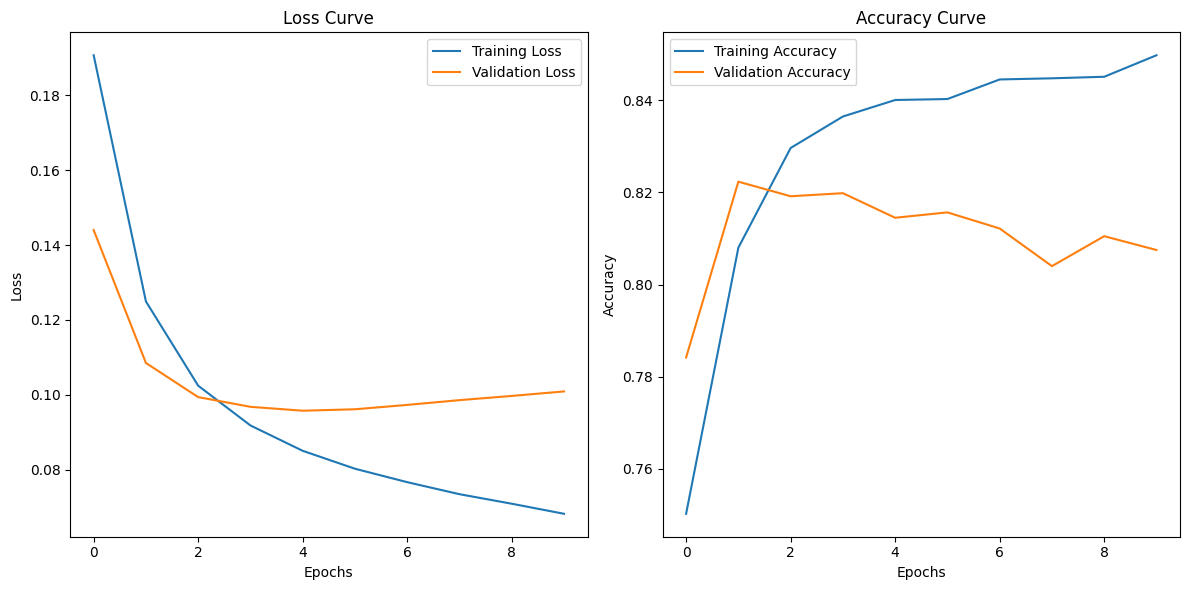

In [143]:
import matplotlib.pyplot as plt

# Tracer la courbe d'apprentissage
plt.figure(figsize=(12, 6))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [180]:
test.shape

(4491, 323)

In [192]:
(model.predict(X_test.iloc[1])[1])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


array([0.49923727, 0.50003093, 0.49984095, 0.49977994, 0.5006444 ,
       0.49941137, 0.49975976, 0.5004896 , 0.49953282, 0.4998557 ,
       0.49937713, 0.50009406, 0.50033545, 0.50073683, 0.5001347 ,
       0.50035584, 0.49948588, 0.50039136], dtype=float32)

In [185]:
# Ensure `test` is a DataFrame
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns  # Import Seaborn for heatmap visualization

X_test = test[[f"dim_{i}" for i in range(300)]].copy()
y_test = test[labels_cols].copy()

# Predict using the model
y_pred_test = model.predict(X_test)

# Generate multilabel confusion matrices
confusion_matrices = multilabel_confusion_matrix(y_test, y_pred_test)

# Visualize the confusion matrix for each label
for i, label in enumerate(classes):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not ' + label, label], yticklabels=['Not ' + label, label])
    plt.title(f'Confusion Matrix for Label: {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

### LSTM with Glove embedding

In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant

# Charger les embeddings GloVe
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Construire le modèle LSTM avec les embeddings GloVe
model_glove = Sequential([
    Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_sequence_length,
        trainable=False
    ),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(len(mlb.classes_), activation='sigmoid')
])

# Compiler le modèle
model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_glove.build(input_shape=(None, max_sequence_length))
model_glove.summary()

c:\Users\jforc\Documents\GitHub\final_projet_lucg\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 50, 300)        │     1,805,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50, 128)        │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,075,926 (7.92 MB)

 Trainable params: 270,226 (1.03 MB)

 Non-trainable params: 1,805,700 (6.89 MB)

In [145]:
model_glove.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - AUC: 0.8330 - loss: 0.2213 - val_AUC: 0.9535 - val_loss: 0.1208
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - AUC: 0.9545 - loss: 0.1165 - val_AUC: 0.9632 - val_loss: 0.1005
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - AUC: 0.9627 - loss: 0.1018 - val_AUC: 0.9665 - val_loss: 0.0940
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - AUC: 0.9662 - loss: 0.0937 - val_AUC: 0.9676 - val_loss: 0.0911
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 46s 61ms/step - AUC: 0.9678 - loss: 0.0906 - val_AUC: 0.9670 - val_loss: 0.0899
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - AUC: 0.9706 - loss: 0.0878 - val_AUC: 0.9676 - val_loss: 0.0887
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - AUC: 0.9732 - loss: 0.0841 - val_AUC: 0.9680 - val_loss: 0.0890
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - AUC: 0.9741 - loss: 0.0819 - val_AUC: 0.9681 - val_loss: 0.0885
Epoch 9/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 

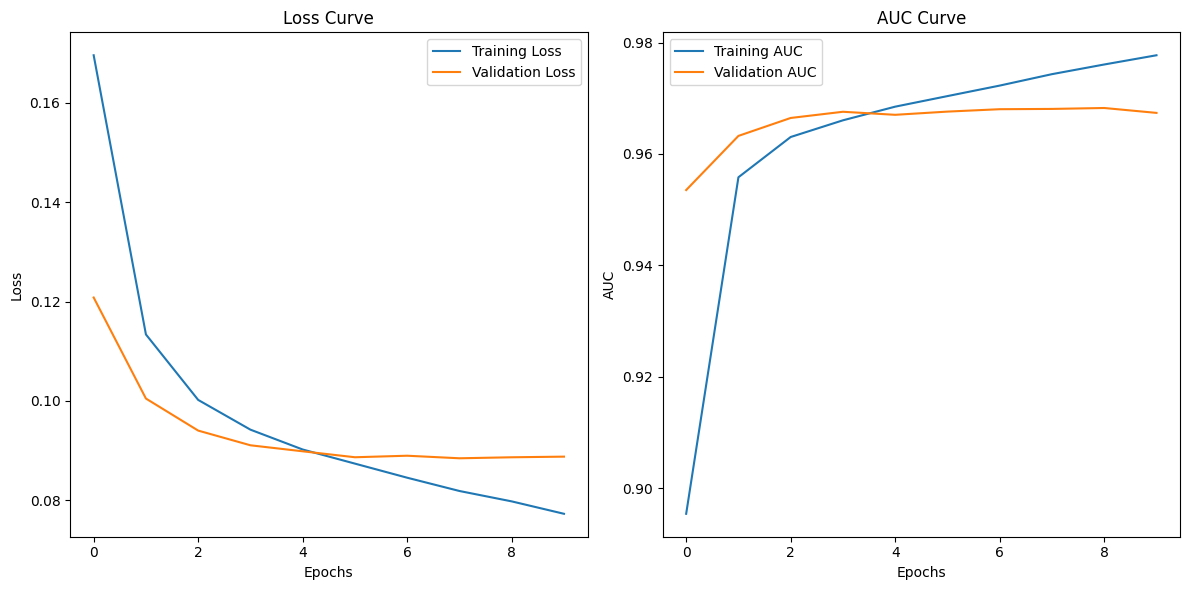

In [155]:
import matplotlib.pyplot as plt

# Tracer la courbe d'apprentissage
plt.figure(figsize=(12, 6))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(model_glove.history.history['loss'], label='Training Loss')
plt.plot(model_glove.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(model_glove.history.history['AUC'], label='Training AUC')
plt.plot(model_glove.history.history['val_AUC'], label='Validation AUC')
plt.title('AUC Curve')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

### LSTM with Glove embedding and CNN

In [162]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.initializers import Constant


hybrid_model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_sequence_length,
        trainable=False
    ),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(len(mlb.classes_), activation='sigmoid')
])

# Compiler le modèle
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Résumé du modèle
hybrid_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 50, 300)        │     1,805,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 46, 128)        │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,138,838 (8.16 MB)

 Trainable params: 333,138 (1.27 MB)

 Non-trainable params: 1,805,700 (6.89 MB)

In [163]:
hybrid_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10


750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - AUC: 0.8377 - loss: 0.2372 - val_AUC: 0.9614 - val_loss: 0.1038
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - AUC: 0.9574 - loss: 0.1088 - val_AUC: 0.9664 - val_loss: 0.0954
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - AUC: 0.9642 - loss: 0.0989 - val_AUC: 0.9637 - val_loss: 0.0957
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - AUC: 0.9692 - loss: 0.0917 - val_AUC: 0.9650 - val_loss: 0.0937
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - AUC: 0.9739 - loss: 0.0849 - val_AUC: 0.9634 - val_loss: 0.0946
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - AUC: 0.9770 - loss: 0.0811 - val_AUC: 0.9593 - val_loss: 0.0993
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - AUC: 0.9806 - loss: 0.0755 - val_AUC: 0.9587 - val_loss: 0.1026
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - AUC: 0.9832 - loss: 0.0713 - val_AUC: 0.9576 - val_loss: 0.1048
Epoch 9/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/st

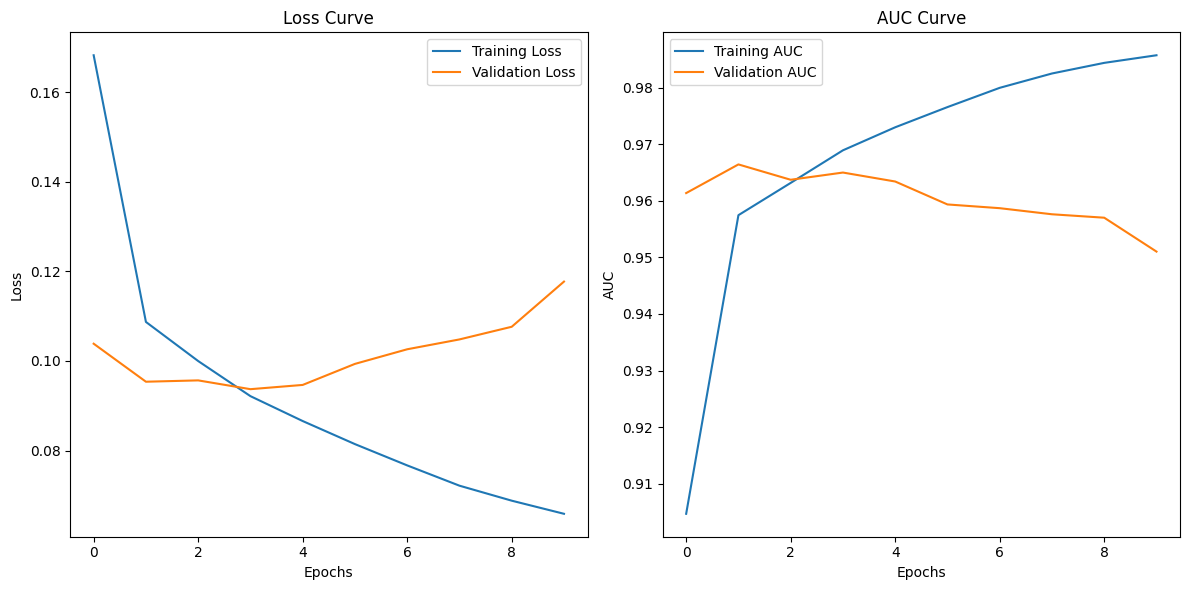

In [165]:

# Tracer la courbe d'apprentissage
plt.figure(figsize=(12, 6))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(hybrid_model.history.history['loss'], label='Training Loss')
plt.plot(hybrid_model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(hybrid_model.history.history['AUC'], label='Training AUC')
plt.plot(hybrid_model.history.history['val_AUC'], label='Validation AUC')
plt.title('AUC Curve')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

```markdown
## Comparaison des résultats et choix du modèle final

### Résultats des modèles testés :
1. **Régression Logistique** :
    - Avantages :
      - Simple à implémenter.
      - Performant sur des données linéairement séparables.
    - Inconvénients :
      - Moins performant sur des données complexes ou non linéaires.
    - Résultats :
      - Classification Report : (voir les métriques détaillées dans les cellules correspondantes).

2. **Random Forest** :
    - Avantages :
      - Capable de capturer des relations non linéaires.
      - Robuste face au surapprentissage.
    - Inconvénients :
      - Plus coûteux en termes de calcul.
    - Résultats :
      - Accuracy : `Random Forest Accuracy: 0.XXXX`
      - F1 Score : `Random Forest F1 Score: 0.XXXX`

3. **Modèles Deep Learning (LSTM)** :
    - **LSTM Scratch** :
      - Avantages :
         - Capable de capturer des relations temporelles dans les données textuelles.
      - Inconvénients :
         - Nécessite un grand volume de données pour de bonnes performances.
      - Résultats :
         - Courbes de perte et de précision (voir les graphiques).
    - **LSTM avec embeddings GloVe** :
      - Avantages :
         - Utilisation d'embeddings pré-entraînés pour une meilleure représentation des mots.
      - Résultats :
         - Courbes de perte et d'AUC (voir les graphiques).
    - **LSTM avec GloVe et CNN** :
      - Avantages :
         - Combinaison des capacités de CNN pour extraire des caractéristiques locales et de LSTM pour capturer des relations séquentielles.
      - Résultats :
         - Courbes de perte et d'AUC (voir les graphiques).

### Choix du modèle final :
- Le choix du modèle dépend des critères suivants :
  - **Performance** : Les métriques comme l'accuracy, le F1 score, et l'AUC.
  - **Complexité** : Temps d'entraînement et de prédiction.
  - **Interprétabilité** : Facilité à expliquer les résultats.

- **Modèle recommandé** : 
  - Si les performances des modèles deep learning (LSTM avec GloVe et CNN) sont significativement meilleures, ils peuvent être choisis comme modèle final.
  - Sinon, le modèle Random Forest peut être préféré pour sa robustesse et sa simplicité d'utilisation.
```